<h1>Home Assignment - Tommasi<h1>

<h2>The Problem</h2>
In this exercise you should count steel bars in the <a href="https://github.com/Armin1337/RebarDSC">RebarDSC dataset</a>.

<h3>Task:</h3>

Write a program that counts the steel bars in the RebarDSC test dataset just based on the available images.

You are allowed to use any programming language, framework and libraries of your choice.

If you are using a supervised learning approach, make sure to not include the test data in your training.

Submit your code and a small report explaining your thoughts and considerations taken during development. If you are working with notebooks feel free to write your report directly in the notebook.

Send your results to: make_an_impact@zupan.io

<h3>Data:</h3>

You can download the data from the github repository. It contains around 2GB of data, images and annotations.

The images are named: rebar_nr_xxMM.jpg, where nr is the image id and xx is the size of the steel bar.

Annotations contain the image name and its bounding boxes in the format: x1 y1 x2 y2, x and y are coordinates of the image given in pixels.

The folders 10%, 20% and 50% are used by the paper for quantitative comparison and are not relevant for the exercise.

<h2>Solution</h2>

Based on the date/time this solution is provided, specifically at 29th February 2024, we are going to use, for this specific problem, the Ultrlytics Framework YOLOv8.

The solution will follow this flow:

<li>Download all the resources</li>
<li>Get an overview of the data we are working with</li>
<li>Install and import all necessaries requirements</li>
<li>Develop functions in order to adapt the current schema to the Ultralytics YOLOv8 schema</li>
<li>Normalize annotations based on YOLOv8 schema</li>
<li>Get a sample of output based on the images and the normalized annotations</li>
<li>Train the model defining the hyper-parameters</li>
<li>Validate the model</li>
<li>Test the model for a sample image to reach the number of elements (rebars) inside an image</li>

<h3>Download all the resources</h3>

For a quick development we are going to download the data and unzip them in the root folder of the project.

The folder structure is as follow:

<img src="./screeshot_1.PNG">

<h3>Install and import all necessaries requirements</h3>

In [ ]:
# Let's install all the requirements

!pip install requests
!pip install opencv-python
!pip install matplotlib
!pip install pandas

In [1]:
import cv2
import matplotlib.pyplot as plt 
import glob
import random
import os
import pandas as pd
import shutil
from ultralytics import YOLO

<h3>Develop functions in order to adapt the current schema to the Ultralytics YOLOv8 schema</h3>

To face this part we have to consider that the provided annotations are not normalized for a YOLOv8 architecture. 

The raw annotations are in this format:

rebar_1006_16MM.jpg,559 333 601 374

rebar_1006_16MM.jpg,609 465 650 507

rebar_1006_16MM.jpg,195 298 237 339

rebar_1006_16MM.jpg,536 212 578 253

And YOLOv8 is using instead this format:

0 0.4223512336719884 0.037290242386575516 0.49637155297532654 0.1019266625233064

0 0.5029027576197388 0.056867619639527654 0.5780116110304789 0.11653200745804848

0 0.5994194484760522 0.043816034804226224 0.6796081277213353 0.1019266625233064

0 0.36937590711175616 0.11684275947793661 0.44194484760522496 0.17868241143567434

For this reason we are going to normalize this coordinate provided using the function <b>load_annotaion_form</b>.

For more info, please see Ultralytics Documentations.

In [13]:
def load_annotation_norm(annotation_file_path, images_folder_path, label, labels_folder_path):
    # Define column names for the DataFrame
    column_names = ["image_name", "x1", "y1", "x2", "y2"]
    # Read the data from the file into a DataFrame
    df = pd.read_csv(annotation_file_path, header=None, names=column_names, sep=",| ")
    print(f"Dataframe shape: {df.shape}")
    # Create a folder called "labels" if it doesn't exist
    if not os.path.exists(labels_folder_path):
        os.makedirs(labels_folder_path)

    # Iterate over unique image names
    unique_image_names = df['image_name'].unique()
    for image_name in unique_image_names:
        # Filter DataFrame for the current image_name
        image_df = df[df['image_name'] == image_name]
        image_name_no_ext = '.'.join(image_name.split(os.path.sep)[-1].split('.')[:-1])
        image_file_path = os.path.join(images_folder_path, f"{image_name_no_ext}.jpg")
        
        # Get image width and height
        img = cv2.imread(image_file_path)
        height, width, _ = img.shape

        # Create a text file for the current image_name
        label_file_path = os.path.join(labels_folder_path, f"{image_name_no_ext}.txt")
        with open(label_file_path, 'w') as label_file:
            # Write label and coordinates to the text file
            for _, row in image_df.iterrows():
                # Divide x by width and y by height
                x1_norm = row['x1'] / width
                y1_norm = row['y1'] / height
                x2_norm = row['x2'] / width
                y2_norm = row['y2'] / height
                label_file.write(f"{label} {x1_norm} {y1_norm} {x2_norm} {y2_norm}\n")

Being the "images" folder the dataset of all the images, we are going to get only the images we are going to really use based on the annotations provided.

For my personal way to take care about the workflow, I prefer not to move information from one side to another, but copy the information first and, after all the data is copied, we are going to delete the temporary folders.

This approach is safer considering eventual corruptions for any reason of the images files due to the moving process.

In [3]:
def get_images_from_label_dir(images_dir, labels_dir, output_image_dir):
    # Create directories if they don't exist
    os.makedirs(output_image_dir, exist_ok=True)
    # Iterate through image files
    for label_file in os.listdir(labels_dir):
        if label_file.endswith(".txt"):
            # Extract filename without extension
            filename = os.path.splitext(label_file)[0]
            # Check if corresponding label file exists
            image_filename = filename + ".jpg"
            if image_filename in os.listdir(images_dir):
                # Copy image file to images_valid directory
                shutil.copy(os.path.join(images_dir, image_filename), os.path.join(output_image_dir, image_filename))

Now, from all the images related to the selected annotations, we are going to set up our model in a 80% of train and in a 20% of validation.

The ratio is defined in a 80/20 way to avoid too much rigidity or too much flexibility of the model itself.

In [30]:
def split_images_and_labels(images_dir, labels_dir, images_train_dir, labels_train_dir, images_valid_dir, labels_valid_dir, split_ratio=0.8):
    # Create directories if they don't exist
    for dir_path in [images_train_dir, labels_train_dir, images_valid_dir, labels_valid_dir]:
        os.makedirs(dir_path, exist_ok=True)

    # Get list of image files
    image_files = [f for f in os.listdir(images_dir) if f.endswith(".jpg") or f.endswith(".JPG")]

    # Shuffle the list of image files
    random.shuffle(image_files)

    # Split the image files based on the split_ratio
    print("Length of image_files:", len(image_files))
    print("Split ratio:", split_ratio)
    num_train_samples = int(len(image_files) * split_ratio)
    train_images = image_files[:num_train_samples]
    valid_images = image_files[num_train_samples:]

    # Copy images and labels to train and validation directories
    for image_file in train_images:
        filename = os.path.splitext(image_file)[0]
        label_file = filename + ".txt"
        shutil.copy(os.path.join(images_dir, image_file), os.path.join(images_train_dir, image_file))
        shutil.copy(os.path.join(labels_dir, label_file), os.path.join(labels_train_dir, label_file))

    for image_file in valid_images:
        filename = os.path.splitext(image_file)[0]
        label_file = filename + ".txt"
        shutil.copy(os.path.join(images_dir, image_file), os.path.join(images_valid_dir, image_file))
        shutil.copy(os.path.join(labels_dir, label_file), os.path.join(labels_valid_dir, label_file))


    shutil.rmtree(images_dir)
    shutil.rmtree(labels_dir)

<h3>Get a sample of output based on the images and the normalized annotations</h3>

We are going to define the functions that allows me to show the boxes (got them from the annotations) for a specific image given in input

In [5]:
def plot_box(image, bboxes, labels):
    # Need the image height and width to denormalize
    # the bounding box coordinates
    h, w, _ = image.shape
    for box in bboxes:
        xmin = int(box[0]*w)
        ymin = int(box[1]*h)
        xmax = int(box[2]*w)
        ymax = int(box[3]*h)
        thickness = max(1, int(w/500))
        cv2.rectangle(
            image, 
            (xmin, ymin), (xmax, ymax),
            color=(0, 0, 255),
            thickness=thickness
        )

    return image
    

In [6]:
def plot(image_paths, label_paths, num_samples):
    # Create a list to store paths of all images
    all_images = []
    # Add paths of JPEG and JPG images to the list
    all_images.extend(glob.glob(image_paths+'/*.jpg'))
    all_images.extend(glob.glob(image_paths+'/*.JPG'))
    
    # Sort the list of image paths
    all_images.sort()
    # Get the total number of images
    num_images = len(all_images)
    
    # Create a matplotlib figure for plotting
    plt.figure(figsize=(15, 12))
    
    # Iterate over the specified number of samples
    for i in range(num_samples):
        # Generate a random index to select an image
        j = random.randint(0,num_images-1)
        # Get the path of the selected image
        image_name = all_images[j]
        print(image_name)

        # Extract the image name from its path
        image_name = '.'.join(image_name.split(os.path.sep)[-1].split('.')[:-1])
        # Read the image using OpenCV
        image = cv2.imread(all_images[j])
        
        # Open the label file corresponding to the image
        with open(os.path.join(label_paths, image_name+'.txt'), 'r') as f:
            bboxes = [] 
            labels = [] 
            label_lines = f.readlines()  
            # Iterate over each line in the label file
            for label_line in label_lines:
                label = label_line[0] 
                bbox_string = label_line[2:]  
                x_c, y_c, w, h = bbox_string.split(' ') 
                x_c = float(x_c) 
                y_c = float(y_c)  
                w = float(w)     
                h = float(h)     
                # Append the bounding box coordinates and label to respective lists
                bboxes.append([x_c, y_c, w, h])
                labels.append(label)
        # Call a function to plot bounding boxes on the image
        result_image  = plot_box(image, bboxes, labels)
        # Create a subplot for the current sample
        plt.subplot(2, 2, i+1)
        # Display the image with plotted bounding boxes
        plt.imshow(result_image[:, :, ::-1]) 
        plt.axis('off') 
    # Adjust the spacing between subplots and layout
    plt.subplots_adjust(wspace=1)
    plt.tight_layout()
    # Show the plot
    plt.show()


<h3>Let's run the code!</h3>

In [27]:
load_annotation_norm('annotations/100_percent_train.csv', 'images', '0', 'labels_')

C:\Users\development\AppData\Local\Temp\ipykernel_9580\2840788991.py:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(annotation_file_path, header=None, names=column_names, sep=",| ")


Dataframe shape: (179713, 5)


In [28]:
get_images_from_label_dir("images", "labels_", "images_")

In [31]:
split_images_and_labels("images_", "labels_", "train/images/", "train/labels", "valid/images", "valid/labels")

Length of image_files: 1125
Split ratio: 0.8


train/images\rebar_384_18MM.jpg
train/images\rebar_1141_18MM.jpg
train/images\rebar_1719_18MM.jpg
train/images\rebar_1444_12MM.jpg


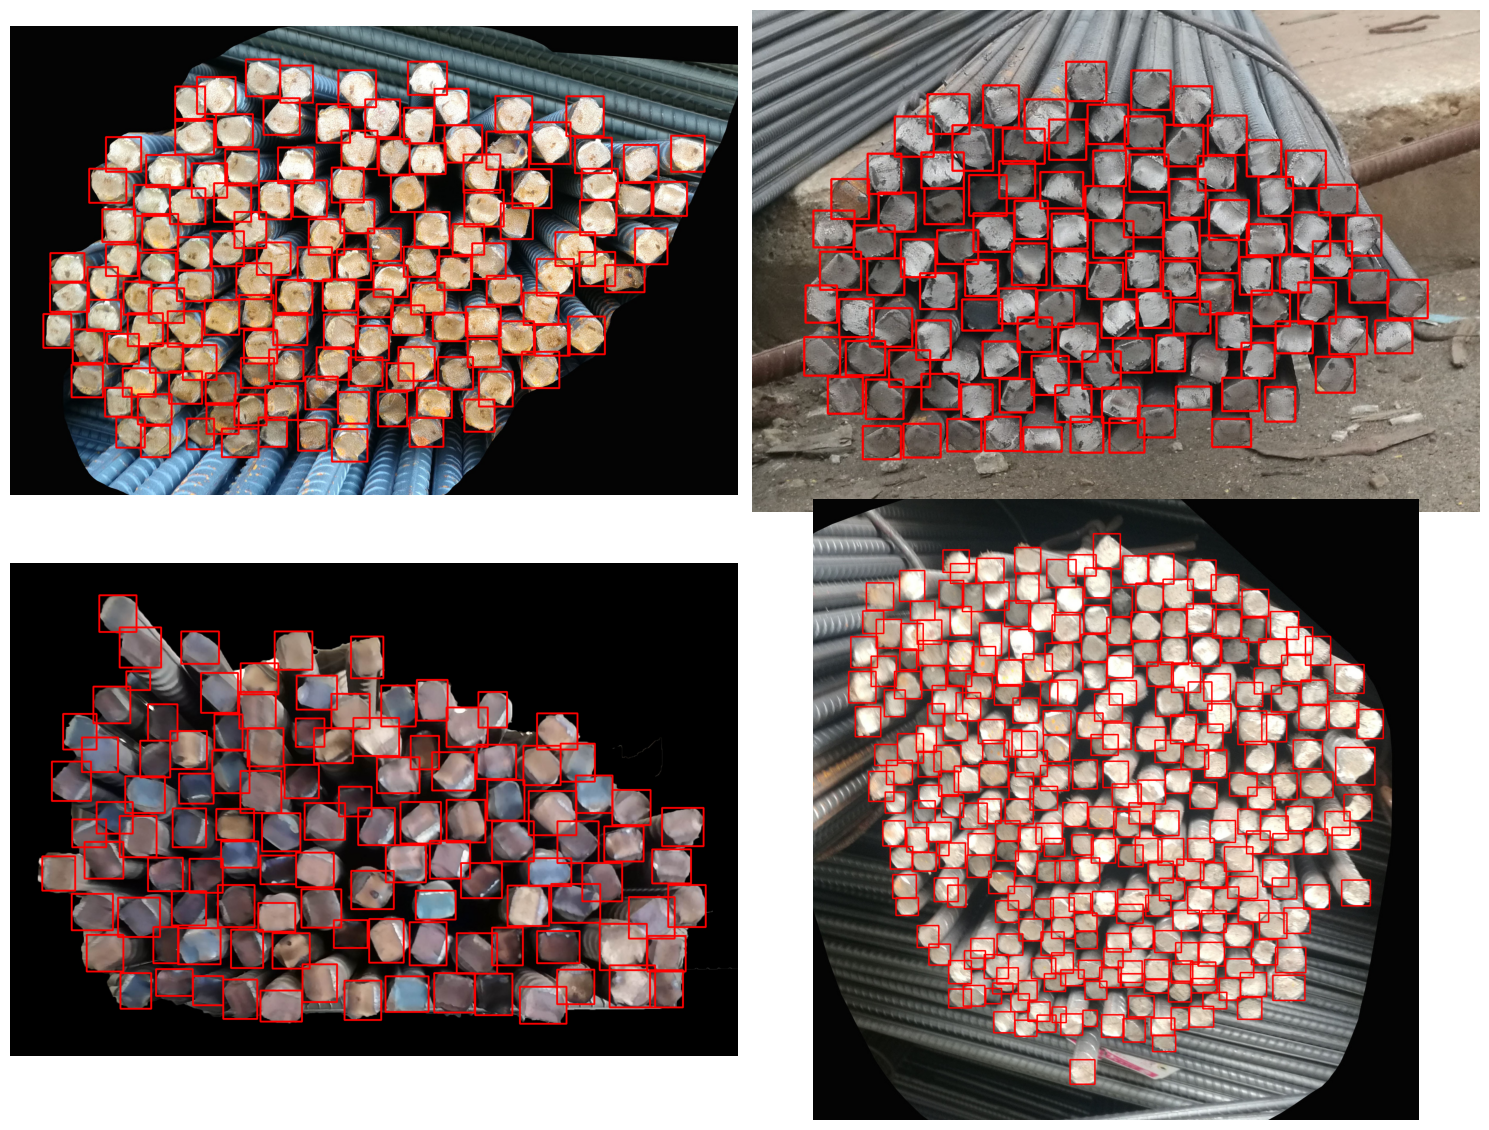

In [33]:
plot(
    image_paths='train/images', 
    label_paths='train/labels',
    num_samples=4,
)

Let's write the configuration file for the model in YOLOv8

In [34]:
%%writefile rebar.yaml
path: './'
train: 'train/images/'
val: 'valid/images/'

nc: 1 
names: ['rebar']

Overwriting rebar.yaml


<h3>Train the model defining the hyper-parameters</h3>

The default image size to train the model is 640x640px. Due to the nature of the object that has to be recognised, we increase the resolution up to 1280x1280px.

This allows me to avoid information and possibles mistakes due to the low resolution.

We need also to remember that more the resolution is high and more computational cost and resources will be required to train thr model.

To train this model and trying to get some results we had to use the yolov8n model, lighter than the yolov8m model.

If we could have more compute resources we were going to use the yolov8m model that for sure it could provide to use more accuracy and precision.

We are going to use this configurartion to render a simple model, even if not accurate about the image dataset we have:
- Image Size: 1280x1280
- Epochs: 5 (not enough for build a good model, it's suggested to achieve at least 25 epochs)
- Number of Batch: 8

As default choice for the YOLO traing, the AdamW algorithm is used for optimisation

In [2]:
!yolo task=detect mode=train model=yolov8n.pt imgsz=1280 data=rebar.yaml epochs=5 batch=8 name=run5_imgsz1280_yolov8n


Ultralytics YOLOv8.1.18 🚀 Python-3.11.4 torch-2.2.1+cpu CPU (Intel Core(TM) i7-9700KF 3.60GHz)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=rebar.yaml, epochs=1, time=None, patience=100, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=run10_imgsz1280_yolov8n2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=Tr


train: Scanning C:\Users\development\Documents\GitHub\HomeTestZupanTommasi\train\labels.cache... 900 images, 0 backgrounds, 0 corrupt: 100%|██████████| 900/900 [00:00<?, ?it/s]
train: Scanning C:\Users\development\Documents\GitHub\HomeTestZupanTommasi\train\labels.cache... 900 images, 0 backgrounds, 0 corrupt: 100%|██████████| 900/900 [00:00<?, ?it/s]

val: Scanning C:\Users\development\Documents\GitHub\HomeTestZupanTommasi\valid\labels.cache... 225 images, 0 backgrounds, 0 corrupt: 100%|██████████| 225/225 [00:00<?, ?it/s]
val: Scanning C:\Users\development\Documents\GitHub\HomeTestZupanTommasi\valid\labels.cache... 225 images, 0 backgrounds, 0 corrupt: 100%|██████████| 225/225 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]
        1/1         0G      2.234      2.618       2.48       3499        640:   0%|          | 0/113 [00:05<?, ?it/s]
        1/1         0G      2.234      2.618       2.48       3499        640:   1%|          | 1/113 [00:05<09:47,  5.25s/it]
       

<h3>Validate the model</h3>

Now, after having created the model based on our images and annotaions, we are going to valuate our model.

The Ultralytics framework will provide to us a list of charts to better undestand our model (correlation matrix and so on)

In [38]:
!yolo task=detect mode=val model=../Ultralytics-YOLO/ultralytics/runs/detect/run5_imgsz1280_yolov8n/weights/best.pt name=yolov8n_eval data=rebar.yaml


Ultralytics YOLOv8.1.18 🚀 Python-3.11.4 torch-2.2.1+cpu CPU (Intel Core(TM) i7-9700KF 3.60GHz)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs
                   all        225      34490      0.601      0.405      0.447      0.261
Speed: 4.9ms preprocess, 255.2ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to c:\Users\development\Documents\GitHub\Ultralytics-YOLO\ultralytics\runs\detect\yolov8n_eval
💡 Learn more at https://docs.ultralytics.com/modes/val



val: Scanning C:\Users\development\Documents\GitHub\HomeTestZupanTommasi\valid\labels.cache... 225 images, 0 backgrounds, 0 corrupt: 100%|██████████| 225/225 [00:00<?, ?it/s]
val: Scanning C:\Users\development\Documents\GitHub\HomeTestZupanTommasi\valid\labels.cache... 225 images, 0 backgrounds, 0 corrupt: 100%|██████████| 225/225 [00:00<?, ?it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/15 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   7%|▋         | 1/15 [00:03<00:50,  3.59s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  13%|█▎        | 2/15 [00:08<00:59,  4.58s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|██        | 3/15 [00:14<01:01,  5.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  27%|██▋       | 4

<h3>Test the model for a sample image to reach the number of elements (rebars) inside an image</h3>

And we are going to detect all the rebars inside the images we have in a specific folder

In [39]:
!yolo task=detect mode=predict model=../Ultralytics-YOLO/ultralytics/runs/detect/yolov8n_v8_50e13/weights/best.pt source=valid/images/ imgsz=1280 name=yolov8n_v8_50e_infer1280 hide_labels=True

WARNING ⚠️ 'hide_labels' is deprecated and will be removed in 'ultralytics 8.299999999999999' in the future. Please use 'show_labels' instead.
Ultralytics YOLOv8.1.18 🚀 Python-3.11.4 torch-2.2.1+cpu CPU (Intel Core(TM) i7-9700KF 3.60GHz)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs

image 1/225 c:\Users\development\Documents\GitHub\HomeTestZupanTommasi\valid\images\rebar_1002_12MM.jpg: 960x1280 59 rebars, 339.9ms
image 2/225 c:\Users\development\Documents\GitHub\HomeTestZupanTommasi\valid\images\rebar_1004_14MM.jpg: 896x1280 57 rebars, 289.8ms
image 3/225 c:\Users\development\Documents\GitHub\HomeTestZupanTommasi\valid\images\rebar_1010_18MM.jpg: 960x1280 12 rebars, 247.7ms
image 4/225 c:\Users\development\Documents\GitHub\HomeTestZupanTommasi\valid\images\rebar_1020_18MM.jpg: 1024x1280 75 rebars, 214.7ms
image 5/225 c:\Users\development\Documents\GitHub\HomeTestZupanTommasi\valid\images\rebar_1063_16MM.jpg: 960x1280 47 rebars, 287.9ms
image 6/225 c:\U

Here, without using a bash command, we are going to detect the number of rebars, based on our custom mode for a specific image

In [35]:
modelPath = 'c:/Users/development/Documents/GitHub/Ultralytics-YOLO/ultralytics/runs/detect/yolov8n_v8_50e13/weights/best.pt'
imagePath = 'images/rebar_2118_12MM.jpg'
model = YOLO(modelPath)
results = model.predict(imagePath, imgsz=1280, conf=0.5)
print(f"The number of detected rebaras are: {len(results[0].boxes)}")


image 1/1 c:\Users\development\Documents\GitHub\HomeTestZupanTommasi\images\rebar_2118_12MM.jpg: 1024x1280 102 rebars, 207.6ms
Speed: 11.0ms preprocess, 207.6ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 1280)
The number of detected rebaras are: 102


The final folder structure is as follow:

<img src="./screeshot_2.PNG">
